In [21]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

# Machine learning libraries
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [22]:
xls_file=pd.ExcelFile("THE_ONE.xlsx") # Read Excel
df=xls_file.parse("returns non-log")

In [23]:
# Flatten multi-index columns
df.columns = df.columns.get_level_values(0) 

In [24]:
#Filtering and Encoding the Target
#What is done:
#the Winning Factor column is filtered to include only valid factor names (those defined in valid_factors).
#The categorical values of the Winning Factor column are then encoded into numerical labels using .astype('category').cat.codes.
#Why:
#Filtering ensures only valid factor data is used for model training, avoiding invalid or missing values.
#Encoding transforms the target into numerical format, which is required by machine learning models for classification.


#Shift the Winning Factor column to represent the next period
# Drop the last row (NaN introduced by the shift)

# Define target: ensure `Winning Factor` aligns with factor_returns columns
valid_factors = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]

# Filter Winning Factor to ensure it matches valid factors
df = df[df['Winning Factor'].isin(valid_factors)]
df = df.reset_index(drop=True)

# Define features
X = df[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance']]

# Encode target as numeric
y = df['Winning Factor'].astype('category').cat.codes
X = X.dropna()
y = y.dropna()
print(X.index.equals(y.index))  # Should return True

True


In [26]:
#Rolling Window Setup
#What is done:
#The data is divided into overlapping rolling windows of size window_size (e.g., 120 months).
#Each window contains a training set (first window_size rows) and a test set (the next row).
#The step_size determines how far the window shifts for the next iteration (e.g., 1 month at a time).
#Why:
#The rolling window simulates a real-world trading environment, where predictions are based only on past data.
#Using rolling windows helps the model adapt to evolving market dynamics.

# Define parameters
window_size = 120  # Size of the rolling window (e.g., 7 years)
step_size = 1     # Step size (e.g., 1 month)

# Ensure dataset is sorted by date
df = df.sort_values('Date').reset_index(drop=True)

# Define factor columns
factor_columns = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]

# Check if required columns are in the DataFrame
required_columns = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'USA Standard (Large+Mid Cap)'] + factor_columns
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

print("Parameters and dataset verified.")

Parameters and dataset verified.


In [27]:
#Model Training and Prediction
#What is done:
#A RandomForestClassifier is trained on the training window (features: economic indicators like VIXCLS, GDPC1, CPI, LEI, 10yr; target: best-performing factor).
#Probabilities are predicted for each factor being the best in the next period.
#Why:
#Random Forests are robust to noisy data and perform well on structured data with categorical targets.
#The predicted probabilities provide a nuanced view of the model’s confidence in each factor.

# Initialize lists to store portfolio returns, probabilities, and feature importances
allocated_returns = []
probability_matrix = []  
probability_dates = []  
feature_importances_list = []  # Store feature importances from each rolling window

# Rolling window loop
for start_idx in range(0, len(df) - window_size, step_size):
    # Define rolling window range
    train_idx = range(start_idx, start_idx + window_size)
    test_idx = [start_idx + window_size]

    # Split data into training and testing
    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]

    # Extract features and target
    X_train = train_data[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance']].dropna()
    y_train = train_data['Winning Factor'].astype('category').cat.codes[X_train.index]
    X_test = test_data[['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance']].dropna()

    # Align indices of features and target
    X_train, y_train = X_train.align(y_train, axis=0)

    # Train the model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Store feature importances
    feature_importances_list.append(rf_model.feature_importances_)

    # Predict probabilities for the test set
    if not X_test.empty:
        probabilities = rf_model.predict_proba(X_test)

        # Calculate portfolio return for the test instance
        portfolio_return = (probabilities * test_data[factor_columns].values).sum(axis=1)
        allocated_returns.extend(portfolio_return)

        # Store probabilities and dates
        probability_matrix.append(probabilities.flatten())
        probability_dates.append(test_data['Date'].values[0])

# Convert feature importance list to NumPy array
feature_importances_array = np.array(feature_importances_list)

# Compute the average feature importance over all rolling windows
average_feature_importance = feature_importances_array.mean(axis=0)



In [28]:
#Portfolio Return Calculation
#What is done:
#Predicted probabilities are used to weight the factor returns in the test period.
#A weighted sum of returns is calculated for each test instance, resulting in the portfolio’s allocated return.
#Why:
#By using probabilities as weights, the strategy dynamically adjusts its exposure to factors with higher predicted performance, simulating an active investment strategy.


# Define aligned indices for test periods dynamically based on window_size
aligned_indices = range(window_size, len(df))

# Convert allocated returns to NumPy array and slice to match aligned_indices
allocated_returns = np.array(allocated_returns)[:len(aligned_indices)]

# Extract benchmark returns dynamically using window_size
benchmark_returns = df.iloc[window_size:]['USA Standard (Large+Mid Cap)'].values[:len(aligned_indices)]

# Verify lengths
print(f"Aligned indices: {len(aligned_indices)}")
print(f"Allocated returns: {len(allocated_returns)}")
print(f"Benchmark returns: {len(benchmark_returns)}")

Aligned indices: 284
Allocated returns: 284
Benchmark returns: 284


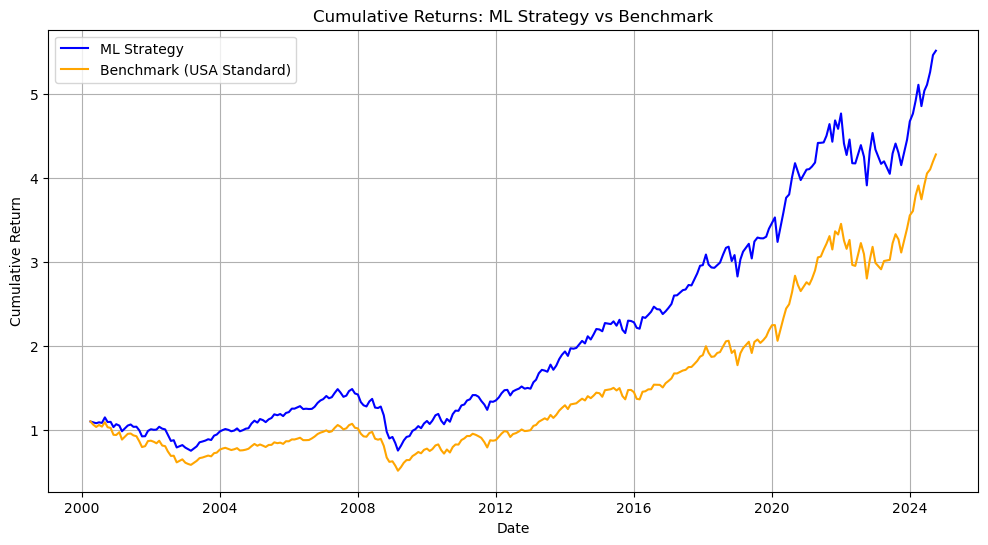

In [29]:
#Cumulative Returns
#Cumulative returns for the ML strategy and the benchmark are calculated by compounding their respective monthly returns over time.
#These are plotted to visualize the portfolio’s growth relative to the benchmark.
#Why:
#Cumulative returns provide a clear picture of the strategy’s performance and whether it outperforms the benchmark over time.

# Compute cumulative returns
cumulative_ml = (1 + allocated_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.loc[aligned_indices, 'Date'][:len(cumulative_ml)], cumulative_ml, label="ML Strategy", color="blue")
plt.plot(df.loc[aligned_indices, 'Date'][:len(cumulative_benchmark)], cumulative_benchmark, label="Benchmark (USA Standard)", color="orange")
plt.title("Cumulative Returns: ML Strategy vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [30]:
# Define metric calculation functions
def annualized_return(returns):
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def annualized_volatility(returns):
    return np.std(returns) * np.sqrt(12)

def sharpe_ratio(returns, risk_free_rate=0.01):
    return (annualized_return(returns) - risk_free_rate) / annualized_volatility(returns)

def tracking_error(strategy_returns, benchmark_returns):
    return np.std(strategy_returns - benchmark_returns) * np.sqrt(12)

def information_ratio(strategy_returns, benchmark_returns):
    excess_returns = annualized_return(strategy_returns) - annualized_return(benchmark_returns)
    return excess_returns / tracking_error(strategy_returns, benchmark_returns)

# Calculate metrics for ML Strategy
ml_annualized_return = annualized_return(allocated_returns)
ml_annualized_volatility = annualized_volatility(allocated_returns)
ml_sharpe_ratio = sharpe_ratio(allocated_returns)
ml_tracking_error = tracking_error(allocated_returns, benchmark_returns)
ml_information_ratio = information_ratio(allocated_returns, benchmark_returns)

# Calculate metrics for Benchmark
benchmark_annualized_return = annualized_return(benchmark_returns)
benchmark_annualized_volatility = annualized_volatility(benchmark_returns)
benchmark_sharpe_ratio = sharpe_ratio(benchmark_returns)

# Create the performance metrics table
metrics_table = pd.DataFrame({
    "Metric": [
        "Annualized Return", 
        "Annualized Volatility", 
        "Sharpe Ratio", 
        "Tracking Error", 
        "Information Ratio"
    ],
    "ML Strategy": [
        f"{ml_annualized_return*100:.2f}%", 
        f"{ml_annualized_volatility*100:.2f}%", 
        f"{ml_sharpe_ratio:.6f}", 
        f"{ml_tracking_error*100:.2f}%", 
        f"{ml_information_ratio:.2f}"
    ],
    "Benchmark": [
        f"{benchmark_annualized_return*100:.2f}%", 
        f"{benchmark_annualized_volatility*100:.2f}%", 
        f"{benchmark_sharpe_ratio:.6f}", 
        "nan%", 
        "nan"
    ]
})

# Print the table
print(metrics_table.to_string(index=False))

               Metric ML Strategy Benchmark
    Annualized Return       7.48%     6.34%
Annualized Volatility      13.39%    14.98%
         Sharpe Ratio    0.484212  0.356240
       Tracking Error       4.17%      nan%
    Information Ratio        0.28       nan


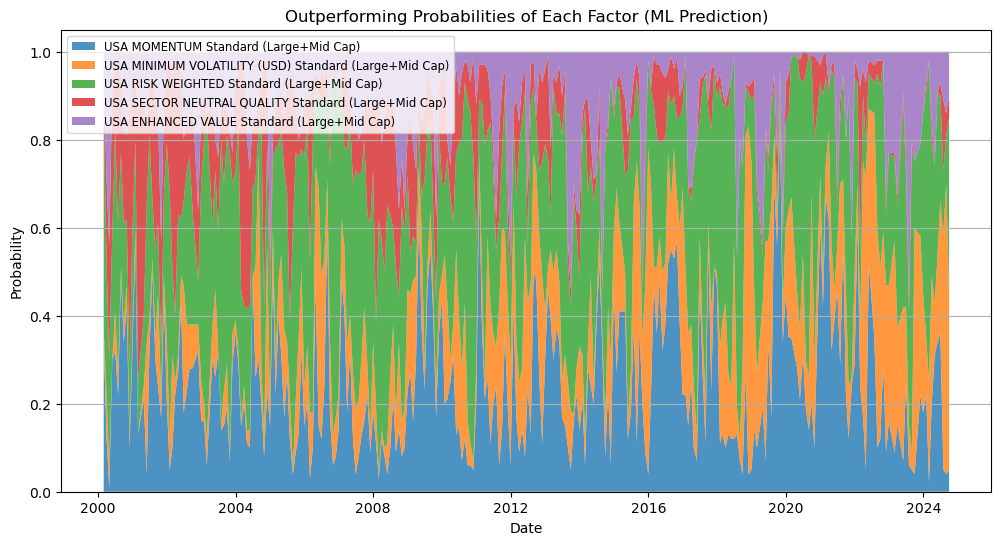

In [10]:
# Convert probabilities to DataFrame
probability_df = pd.DataFrame(
    probability_matrix,
    columns=[
        'USA MOMENTUM Standard (Large+Mid Cap)',
        'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
        'USA RISK WEIGHTED Standard (Large+Mid Cap)',
        'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
        'USA ENHANCED VALUE Standard (Large+Mid Cap)'
    ]
)

# Add the corresponding dates
probability_df['Date'] = probability_dates

# Plot probabilities as a stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df['Date'],
    probability_df['USA MOMENTUM Standard (Large+Mid Cap)'],
    probability_df['USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)'],
    probability_df['USA RISK WEIGHTED Standard (Large+Mid Cap)'],
    probability_df['USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)'],
    probability_df['USA ENHANCED VALUE Standard (Large+Mid Cap)'],
    labels=[
        'USA MOMENTUM Standard (Large+Mid Cap)',
        'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
        'USA RISK WEIGHTED Standard (Large+Mid Cap)',
        'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
        'USA ENHANCED VALUE Standard (Large+Mid Cap)'
    ],
    alpha=0.8
)
plt.title("Outperforming Probabilities of Each Factor (ML Prediction)")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend(loc='upper left', fontsize='small')
plt.grid(axis='y')
plt.show()

In [11]:
# Define feature names
feature_names = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance']

# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": average_feature_importance
}).sort_values(by="Importance", ascending=False)

# Display the table
print(feature_importance_df.to_string(index=False))

             Feature  Importance
              VIXCLS    0.188030
Financial Turbulance    0.181501
                10yr    0.175600
                 LEI    0.160681
                 CPI    0.158747
               GDPC1    0.135441


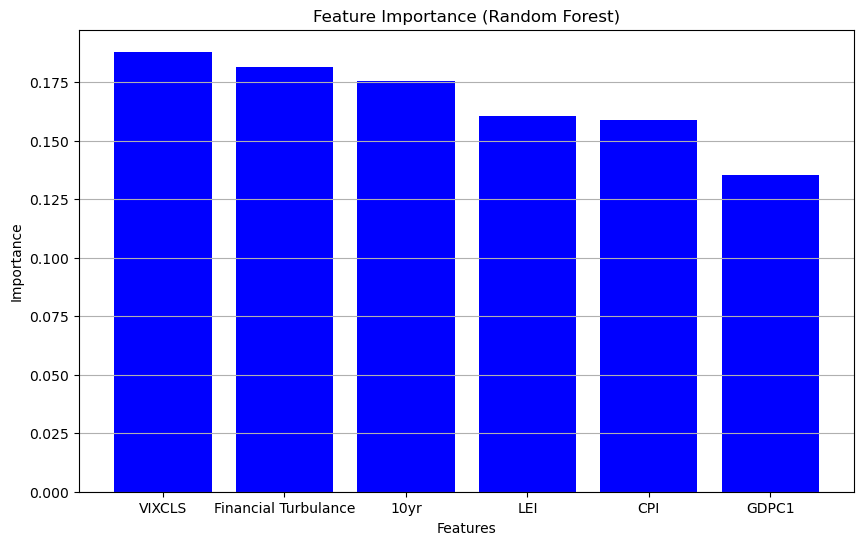

In [12]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid(axis="y")
plt.show()